# Compare CESM2 historic conditions in line with ERA5

- Calculates spatial mean over full domain (removing land points) between 80S to 58S
- On the original ERA5 and CESM2 grids, grid cells not area-weighted (for simplicity, obviously not exactly correct)
- Annual means (easy to regrid to other frequencies)

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import sys
import cmocean
from dateutil.relativedelta import relativedelta
import datetime
sys.path.append('/home/users/birgal/')
from nemo_python_git.utils import fix_lon_range
from nemo_python_git.file_io import find_cesm2_file, find_processed_cesm2_file
from nemo_python_git.atm_calc import wind_curl, wind_divergence

In [2]:
base_dir  = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
cesm2_dir = f'{base_dir}climate-forcing/CESM2/LE2/'
era5_dir  = f'{base_dir}ERA5-forcing/'

In [3]:
for var in ['d2m']:
    print(var)
    ds = xr.open_dataset(f'{era5_dir}hourly/{var}_y1989m02.nc')

    # CESM2 does not do leap years, but NEMO does, so fill 02-29 with 02-28        
    # Also convert calendar to Gregorian
    ds['time'] = ds.time - np.timedelta64(366, 'D') 
    fill_value = ds.isel(time=((ds.time.dt.month==2)*(ds.time.dt.day==28)))
    fill_value['time'] = fill_value.time + np.timedelta64(1, 'D')

    ds_new = xr.concat([ds, fill_value], dim='time')
    ds_new.to_netcdf(f'{era5_dir}hourly/{var}_y1988m02_tempfill.nc', unlimited_dims=['time'])

d2m


In [24]:
dsu3 = xr.open_dataset(f'{era5_dir}hourly/raw/u10_y1988.nc').rename({'valid_time':'time'})
dsv3 = xr.open_dataset(f'{era5_dir}hourly/raw/u10_y1988.nc').rename({'valid_time':'time'})
dsu3 = dsu3.isel(time=(dsu3.time.dt.month==1))
dsv3 = dsv3.isel(time=(dsv3.time.dt.month==1))

In [25]:
dsu1 = xr.open_dataset(f'{era5_dir}hourly/u10_y1987m01.nc')
dsv1 = xr.open_dataset(f'{era5_dir}hourly/v10_y1987m01.nc')
dsu2 = xr.open_dataset(f'{era5_dir}hourly/processed/u10_y1988.nc')
dsu2 = dsu2.isel(time=(dsu2.time.dt.month==1)).rename({'lon':'longitude', 'lat':'latitude'})
dsv2 = xr.open_dataset(f'{era5_dir}hourly/processed/v10_y1988.nc')
dsv2 = dsv2.isel(time=(dsv2.time.dt.month==1)).rename({'lon':'longitude', 'lat':'latitude'})
dsu2['longitude'] = fix_lon_range(dsu2['longitude'], max_lon=360)
dsv2['longitude'] = fix_lon_range(dsv2['longitude'], max_lon=360)
dsu2 = dsu2.sortby('longitude')
dsv2 = dsv2.sortby('longitude')
# need to rename: lon: longitude, lat:latitude, convert longitude back from -180--> 180 to 0 --> 360

In [26]:
dsu4 = dsu1.copy()
dsu4['time'] = dsu3.time
dsu4['u10'] = dsu3.u10

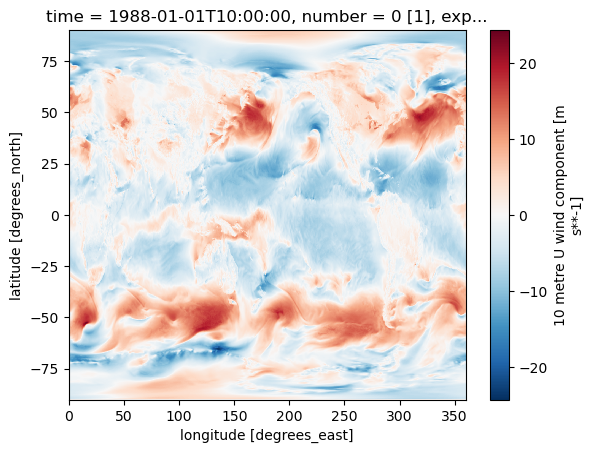

In [28]:
dsu4.u10.isel(time=10).plot()

In [5]:
landmask = xr.open_dataset(f'{era5_dir}climatology/land_sea_mask.nc').isel(time=0).lsm #.rename({'longitude':'lon','latitude':'lat'})
# landmask['lon'] = fix_lon_range(landmask['lon'])
# landmask = landmask.sortby('lon')

In [6]:
dsu_nan = xr.where(landmask!=0, np.nan, dsu2['u10'])
# dsu_nan = dsu_nan.reindex(latitude = -1*dsu_nan.latitude)

# data[varname] = (('lat','lon','time'), var_filled_array)
# data = data.transpose('time','lat','lon')


In [20]:
var='t2m'
for year in range(1988, 1989):
    # ds = xr.open_dataset(f'{era5_dir}hourly/processed/{var}_y{year}.nc').rename({'lon':'longitude', 'lat':'latitude'})
    ds = xr.open_dataset(f'{era5_dir}hourly/raw/{var}_y{year}.nc').rename({'valid_time':'time'})
    # ds['longitude'] = fix_lon_range(ds['longitude'], max_lon=360)
    ds = ds.sortby('longitude')
    name_remap  = {'msdwlwrf':'avg_sdlwrf', 'msdwswrf':'avg_sdswrf', 'mtpr':'avg_tprate', 'msr':'avg_tsrwe'}
    try:
        ds = ds.rename({f'{name_remap[var]}':var})
        print(f'remapping {name_remap[var]} to {var}')
    except:
        pass

    for month in range(1,13):
        print(month)
        ds_sub = ds.isel(time=(ds.time.dt.month==month))
        
        ds_sub.to_netcdf(f'{era5_dir}hourly/processed/{var}_y{year}m{month:02}.nc', unlimited_dims={'time':True})

7
8
9
10
11
12


In [36]:
dsu20 = dsu1.copy()
dsu20['u10'] = dsu2['u10']

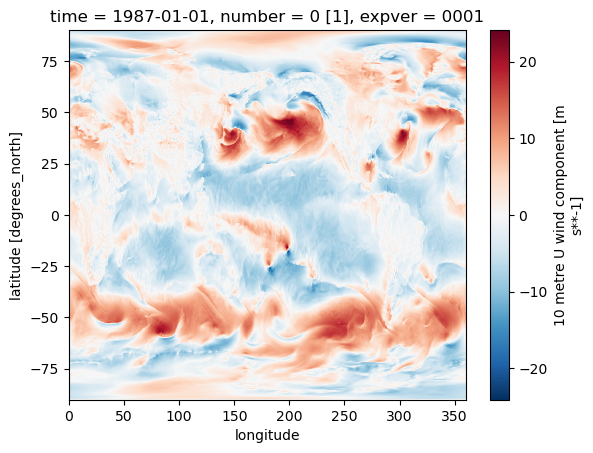

In [37]:
dsu20['u10'].isel(time=0).plot()

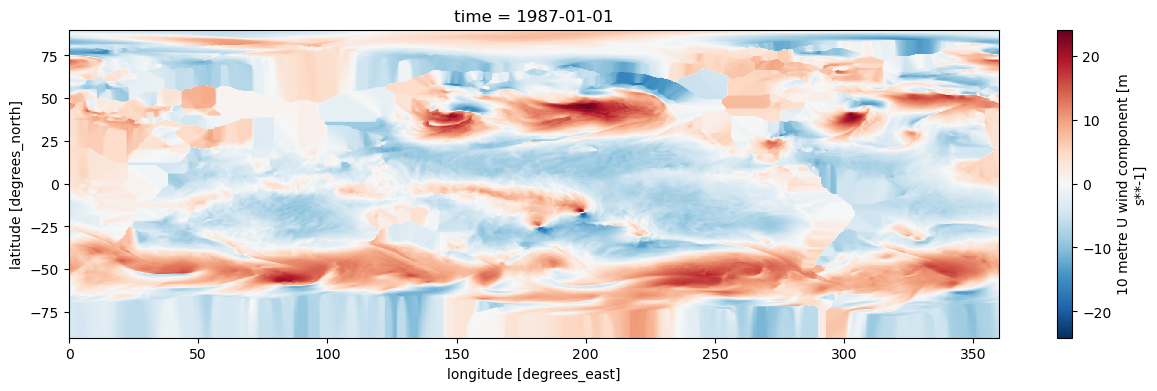

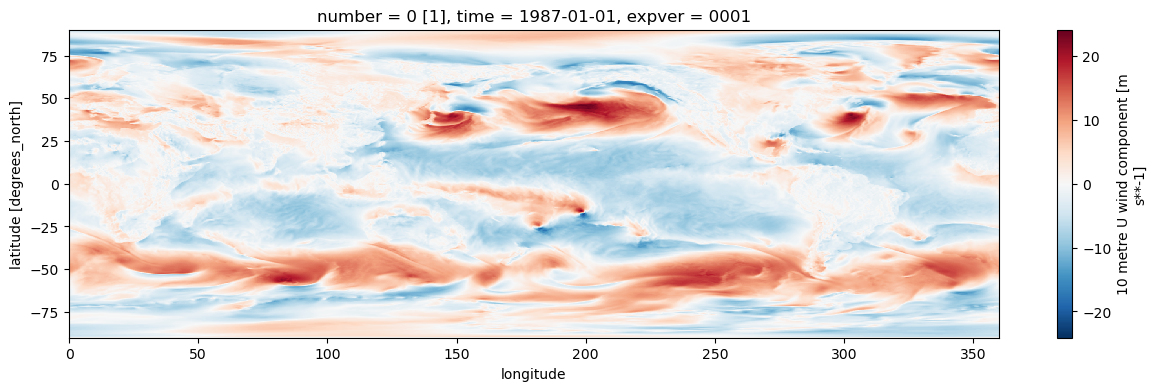

In [26]:
dsu1[.u10.isel(time=0).plot(figsize=(15,4))
dsu2.u10.isel(time=0).plot(figsize=(15,4))

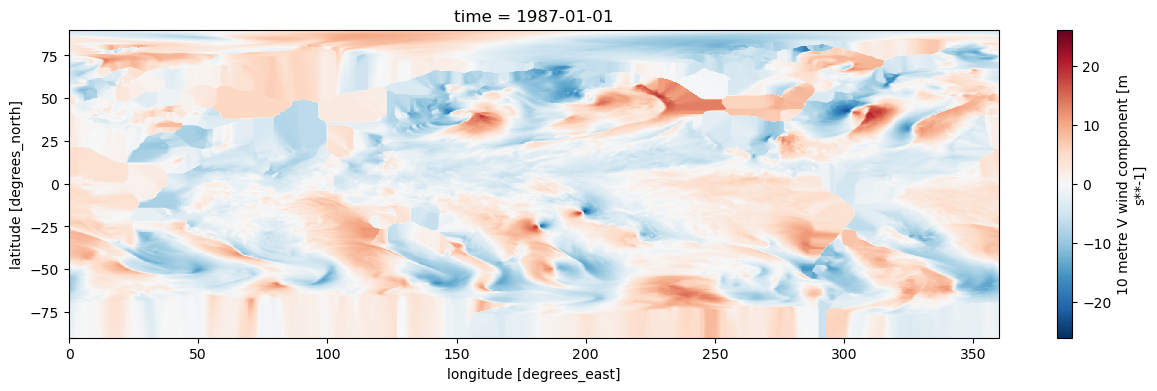

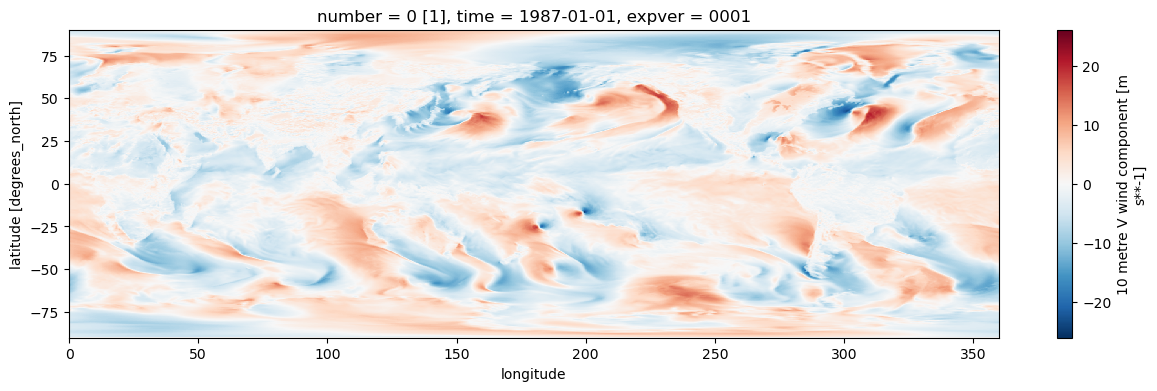

In [28]:
dsv1.v10.isel(time=0).plot(figsize=(15,4))
dsv2.v10.isel(time=0).plot(figsize=(15,4))